Saving nutrition.csv to nutrition (2).csv
Available columns: ['unnamed: 0', 'name', 'serving_size', 'calories', 'total_fat', 'saturated_fat', 'cholesterol', 'sodium', 'choline', 'folate', 'folic_acid', 'niacin', 'pantothenic_acid', 'riboflavin', 'thiamin', 'vitamin_a', 'vitamin_a_rae', 'carotene_alpha', 'carotene_beta', 'cryptoxanthin_beta', 'lutein_zeaxanthin', 'lucopene', 'vitamin_b12', 'vitamin_b6', 'vitamin_c', 'vitamin_d', 'vitamin_e', 'tocopherol_alpha', 'vitamin_k', 'calcium', 'copper', 'irom', 'magnesium', 'manganese', 'phosphorous', 'potassium', 'selenium', 'zink', 'protein', 'alanine', 'arginine', 'aspartic_acid', 'cystine', 'glutamic_acid', 'glycine', 'histidine', 'hydroxyproline', 'isoleucine', 'leucine', 'lysine', 'methionine', 'phenylalanine', 'proline', 'serine', 'threonine', 'tryptophan', 'tyrosine', 'valine', 'carbohydrate', 'fiber', 'sugars', 'fructose', 'galactose', 'glucose', 'lactose', 'maltose', 'sucrose', 'fat', 'saturated_fatty_acids', 'monounsaturated_fatty_aci

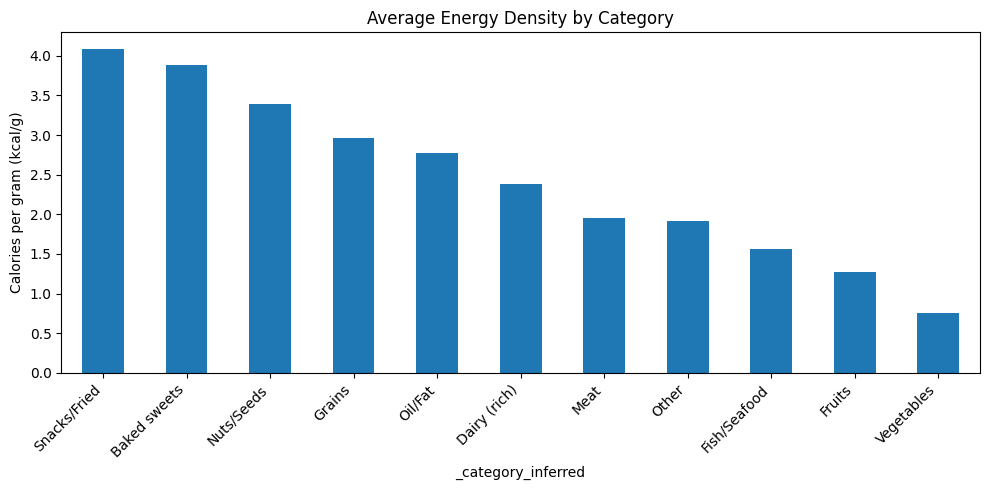

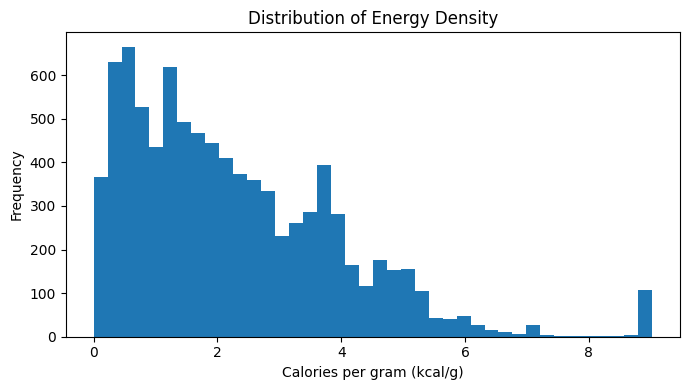


Saved: energy_density_ranked.csv (ตารางจัดอันดับ kcal/g)


In [2]:
# ==========================================
# Energy Density (Calories per gram) – Colab Ready
# ใช้กับไฟล์ nutrition.csv ที่อัปโหลด
# ==========================================

import re, numpy as np, pandas as pd
import matplotlib.pyplot as plt

# -- 1) Upload & Load
from google.colab import files
uploaded = files.upload()  # เลือกไฟล์ nutrition.csv
df = pd.read_csv("nutrition.csv", encoding_errors="ignore")

# -- 2) Normalize column names (ให้ robust ต่อเคสต่าง ๆ)
df.columns = [c.strip().lower() for c in df.columns]
print("Available columns:", df.columns.tolist())

# -- 3) Helper: หา column ตาม candidates หลายชื่อ
def find_col(candidates, cols):
    for cand in candidates:
        if cand in cols:
            return cand
    # ลองจับ pattern แบบใกล้เคียง (เช่น 'weight (g)')
    for c in cols:
        for pat in candidates:
            if re.sub(r'[^a-z]', '', pat) in re.sub(r'[^a-z]', '', c):
                return c
    return None

# คอลัมน์ชื่ออาหาร
name_col = find_col(["food", "name", "item"], df.columns) or "name"

# คอลัมน์แคลอรี่
cal_col = find_col(["calories","energy_kcal","kcal","energy (kcal)"], df.columns)
if cal_col is None:
    raise ValueError("ไม่พบคอลัมน์แคลอรี่ (ลองดูว่าไฟล์มี 'calories' / 'energy_kcal' / 'kcal' หรือไม่)")

# คอลัมน์น้ำหนักกรัมต่อเสิร์ฟ
g_col = find_col([
    "serving_size","serving size","serving_size_g","serving (g)",
    "weight (g)","weight_g","grams","grams_per_serving"
], df.columns)
if g_col is None:
    raise ValueError("ไม่พบคอลัมน์น้ำหนักกรัมต่อเสิร์ฟ (ลองดู 'serving_size' / 'weight (g)' ฯลฯ)")

# -- 4) Clean numeric
for col in [cal_col, g_col]:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(r"[^\d\.\-eE]", "", regex=True)  # ตัดหน่วยเช่น 'g'
        .replace({"": np.nan})
        .astype(float)
    )

# -- 5) คำนวณ Energy Density = calories / grams
df = df.dropna(subset=[cal_col, g_col]).copy()
df = df[df[g_col] > 0]  # กันหารศูนย์/ค่าผิดปกติ
df["energy_density"] = df[cal_col] / df[g_col]

print("\nตัวอย่างข้อมูลหลังคำนวณ:")
print(df[[name_col, cal_col, g_col, "energy_density"]].head(5))

# -- 6) จัดอันดับพลังงานต่อกรัม สูงสุด/ต่ำสุด
topn = 15
print(f"\nTop {topn} Foods by Energy Density (kcal/g):")
print(df[[name_col, "energy_density"]].sort_values("energy_density", ascending=False).head(topn))

print(f"\nBottom {topn} Foods by Energy Density (kcal/g):")
print(df[[name_col, "energy_density"]].sort_values("energy_density", ascending=True).head(topn))

# -- 7) สร้างกลุ่มแบบง่าย (ถ้าไม่มี column 'category') จากคีย์เวิร์ดในชื่ออาหาร
if "category" in df.columns:
    cat_col = "category"
else:
    def infer_category(x):
        x = str(x).lower()
        if any(k in x for k in ["oil","butter","lard","shortening","mayonnaise"]): return "Oil/Fat"
        if any(k in x for k in ["nut","almond","cashew","peanut","walnut","seed","sesame","sunflower"]): return "Nuts/Seeds"
        if any(k in x for k in ["cake","cookie","pastry","donut","croissant","muffin","pie","biscuit"]): return "Baked sweets"
        if any(k in x for k in ["chip","fries","crisps"]): return "Snacks/Fried"
        if any(k in x for k in ["cheese","cream","ice cream"]): return "Dairy (rich)"
        if any(k in x for k in ["meat","pork","beef","chicken","bacon","sausage"]): return "Meat"
        if any(k in x for k in ["fish","salmon","tuna","shrimp"]): return "Fish/Seafood"
        if any(k in x for k in ["vegetable","lettuce","spinach","cabbage","kale","broccoli"]): return "Vegetables"
        if any(k in x for k in ["fruit","apple","banana","orange","berry","grape","melon","mango","pineapple"]): return "Fruits"
        if any(k in x for k in ["rice","noodle","pasta","bread","cereal","oat","grain"]): return "Grains"
        return "Other"
    cat_col = "_category_inferred"
    df[cat_col] = df[name_col].apply(infer_category)

# -- 8) ค่าเฉลี่ยพลังงานต่อกรัมตามกลุ่ม
group_mean = (
    df.groupby(cat_col, dropna=False)["energy_density"]
      .mean()
      .sort_values(ascending=False)
)
print("\nAverage Energy Density by Category (kcal/g):")
print(group_mean)

# -- 9) Visualization
plt.figure(figsize=(10,5))
group_mean.plot(kind="bar")
plt.ylabel("Calories per gram (kcal/g)")
plt.title("Average Energy Density by Category")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ฮิสโตแกรมภาพรวมพลังงานต่อกรัม
plt.figure(figsize=(7,4))
df["energy_density"].plot(kind="hist", bins=40)
plt.xlabel("Calories per gram (kcal/g)")
plt.title("Distribution of Energy Density")
plt.tight_layout()
plt.show()

# -- 10) บันทึกผลสรุป
out = df[[name_col, cal_col, g_col, "energy_density", cat_col]].copy()
out = out.sort_values("energy_density", ascending=False)
out.to_csv("energy_density_ranked.csv", index=False)
print("\nSaved: energy_density_ranked.csv (ตารางจัดอันดับ kcal/g)")

